# Monte Carlo estimation of Sensitivities in Finance
## MATH-414 Stochastic Simulation project
Authors : Charles Gendreau - Eliott Van Dieren

Professor : Prof. Fabio Nobile

Teaching Assistant : Sundar Ganesh

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import time

## 1. Simulation functions

In [2]:
# Utility functions 
def simul_S_T(params:list,n:int,W_T : np.array) -> np.array:
    """
    Returns a numpy array of size n with prices of the underlying at maturity
    
    Args :
        - params is a list of the following values :
            * T : Time of maturity in years (float)
            * S_0 : Underlying price at time 0 (float)
            * r : free-risk interest rate (float)
            * sig : Volatility of the underlying (float)
        - n : number of prices (int)
    Returns :
        - numpy array of S_T
    """
    T : float = params[0]; S_0 : float = params[1]
    r : float = params[2]; sig : float = params[3]
    return S_0*np.exp((r-0.5*sig**2)*T+sig*W_T)


def CMC_estimator(func,X:np.array,params:list) -> list:
    """
    Crude Monte-Carlo estimator of E[func(X)]
    (Simulaton has to be done prior to using this function and stored in X)
    args:
        - func : function from R^N to R^N where N = length of X
        - X : numpy array
        - params : list of parameters for the func function
    returns : 
        - Crude Monte-Carlo estimator of the mean
        - Standard deviation (for CI purposes)    
    """
    return np.array([np.mean(func(X,params)),np.std(func(X,params))])

def finite_difference(func,params:list,dtheta:float,derivative:str, n:int, w_stud:bool,init_W_T=None) -> np.array:
    """
    Finite difference method to compute the derivative of I := E[func(S_T)] wrt theta
    
    I is computed with the CMC_estimator function which takes func, S_T and params as argument
    
    args:
        - func : function from R^N to R^N which takes S_T as parameter (payoff function)
        - params is a list of the following values :
            * T : Time of maturity in years (float)
            * S_0 : Underlying price at time 0 (float)
            * r : free-risk interest rate (float)
            * sig : Volatility of the underlying (float)
            * K : Strike price for the payoff
        - dtheta : small delta of theta to compute the finite difference (float)
        - derivative : either "delta", "vega" or "gamma"
        - n : number of simulations for Monte-Carlo
        - w_stud : True if study on diff W_T simul, false else
        - init_W_T : np array of W_T of size n
    returns : the estimated value of dI/dtheta by finite difference method and its standard deviation
    
    """
    
    if derivative not in ["delta","vega","gamma"]:
        print(f"Derivative not supported : {derivative}")
        raise ValueError
    
    idx_deriv : int = 3 if derivative == "vega"  else 1 # Useful to know which parameter we have to modify
    
    # Definition of new parameters
    params_pos : list = params.copy(); params_neg : list = params.copy()
    params_pos[idx_deriv] += dtheta ; params_neg[idx_deriv] -= dtheta
    
    # Generation of Brownian motion
    if w_stud:
        W_T_1 : np.array = st.norm.rvs(loc=0,scale=np.sqrt(params[0]),size=n)
        W_T_2 : np.array = st.norm.rvs(loc=0,scale=np.sqrt(params[0]),size=n)
        if derivative == "gamma":
            W_T_3 : np.array = st.norm.rvs(loc=0,scale=np.sqrt(params[0]),size=n)
            W_T : list = [W_T_1,W_T_2,W_T_3]
        else:
            W_T : list = [W_T_1,W_T_2]
    else:
        W_T_1: np.array = st.norm.rvs(loc=0,scale=np.sqrt(params[0]),size=n)
        W_T : list = [W_T_1,W_T_1]
    
    if init_W_T is not None: # Fixing the W_T for the delta theta question
        W_T : list = [init_W_T,init_W_T]
    
    diff_f = lambda x,p : func(x[0],p[0])-func(x[1],p[1]) # x = [S_T_pos,neg], p = [params_pos,neg]
    diff_f_2 = lambda x,p : func(x[0],p[0])-2*func(x[2],p[2])+func(x[1],p[1]) # x = [S_T_pos,neg,S_T], p = [params_pos,neg,params] 
    
    # Generation of payoff estimates
    if derivative == "gamma": # Due to different equation for second order derivative estimates
        S_T_tot = [simul_S_T(params_pos,n,W_T[2]),simul_S_T(params_neg,n,W_T[0]),simul_S_T(params,n,W_T[1])]
        params_tot = [params_pos,params_neg,params]
        mu_std = CMC_estimator(diff_f_2,S_T_tot,params_tot) 
        return mu_std/(dtheta**2)
    else: # For delta and vega
        S_T_tot = [simul_S_T(params_pos,n,W_T[0]),simul_S_T(params_neg,n,W_T[1])]
        params_tot = [params_pos,params_neg]
        mu_std = CMC_estimator(diff_f,S_T_tot,params_tot)
        return 0.5*mu_std/dtheta
    
def pathwise_deriv(dfunc, params:list,dSdtheta,derivative:str, n:int) -> np.array:
    """
    1st order pathwise derivative method to compute the derivative of I := E[func(S_T)] wrt theta
        
    args:
        - dfunc : function from R^N to R^N which takes S_T as parameter (derivative of payoff function)
        - params is a list of the following values :
            * T : Time of maturity in years (float)
            * S_0 : Underlying price at time 0 (float)
            * r : free-risk interest rate (float)
            * sig : Volatility of the underlying (float)
            * K : Strike price for the payoff
        - dSdtheta : function of derivative of S_T wrt theta (takes W_T and parameters as input)
        - derivative : either "delta", "vega" or "combination". "combination" is used for LRPD for gamma estimation
        - n : number of simulations for Monte-Carlo
        
    returns : the estimated value of dI/dtheta by pathwise derivative and its standard deviation
    
    """
    
    if derivative not in ["delta","vega","combination"]:
        print(f"Derivative not supported : {derivative}")
        raise ValueError
        
    W_T : np.array = st.norm.rvs(loc=0,scale=np.sqrt(params[0]),size=n)
    S_T : np.array = simul_S_T(params,n,W_T)
    path_deriv = lambda x,params : dfunc(x,params)*dSdtheta(W_T,params)

    return CMC_estimator(path_deriv,S_T,params)


def likelihood_ratio(func,dp,params:list,derivative:str,n:int) -> np.array:
    """
    Likelihood ratio method to compute the derivative of I := E[func(S_T)] wrt theta
        
    args:
        - func : function from R^N to R^N which takes S_T as parameter (payoff function)
        - dp : function from R^N to R^N which takes S_T as parameter (partial deriv wrt theta of pdf of S_t)
        - params is a list of the following values :
            * T : Time of maturity in years (float)
            * S_0 : Underlying price at time 0 (float)
            * r : free-risk interest rate (float)
            * sig : Volatility of the underlying (float)
            * K : Strike price for the payoff
        - derivative : either "delta", "vega"
        - n : number of simulations for Monte-Carlo
        
    returns : the estimated value of dI/dtheta by pathwise derivative and its standard deviation
    
    """
    
    if derivative not in ["delta","vega", "gamma"]:
        print(f"Derivative not supported : {derivative}")
        raise ValueError
        
    W_T : np.array = st.norm.rvs(loc=0,scale=np.sqrt(params[0]),size=n)
    S_T : np.array = simul_S_T(params,n,W_T)
    f = lambda x,params : func(x,params)*dp(x,params)
    
    return CMC_estimator(f,S_T,params)

## 2. European Call Option

### 2.1 Estimating Delta and Vega using Finite Difference, pathwise derivative and likelihood ratio methods

In [3]:
# Parameters
T : float = 1
S_0 : float = 100
K : float = 120
r : float = 0.05
sig : float = 0.25
params : list = [T,S_0,r,sig,K]
dtheta : float = 1e-6

greeks = ["delta","vega"]

# Payoff function for European Call Option
C_payoff = lambda x,p: np.exp(-p[2]*p[0])*np.maximum(x-p[4],np.zeros(len(x)))

# Derivative function for European Call Option
dC_payoff = lambda x,p: np.exp(-p[2]*p[0])*(x>p[4])

# Derivative of S_T wrt parameters
dS_dS0 = lambda x,p : np.exp((p[2]-0.5*p[3]**2)*p[0]+p[3]*x) # x = W_T
dS_dS02 = lambda x,p : np.zeros(len(x)) # as it is linear wrt S_0
dS_dsig = lambda x,p: p[1]*np.exp((p[2]-0.5*p[3]**2)*p[0]+p[3]*x)*(x-p[3]*p[0]) # x = W_T

# Parameters for simulation
n_elem : np.array = np.logspace(3,6,100).astype(int)
n_max = n_elem[-1]
dthetas : np.array = np.logspace(-12,-1,100).astype(float)

In [4]:
# Finite difference method dictionnaries
finite_methods_dict = {}
finite_methods_dict_W_T_diff = {}
finite_methods_dthetas = {}

# Main method, with one W_T for I(theta +/- dtheta)
start = time.time()
for greek in greeks:
    start = time.time()
    finite_methods_dict[greek] = np.array([finite_difference(C_payoff,params,dtheta,greek, n,False,None) for idx,n in enumerate(n_elem)])
end = time.time()

print("With one W_T sample : ",end-start)

# Second method, with two different W_T for I(theta +/- dtheta)
start = time.time()
for greek in greeks:
    finite_methods_dict_W_T_diff[greek] = np.array([finite_difference(C_payoff,params,dtheta,greek, n,True,None) for idx,n in enumerate(n_elem)])
end = time.time()
print("With 2 samples : ",end-start)



# Computing with FD method with variation of dtheta
# Approx running time 3min so comment if it takes too long
# then also comment for Figure 2
n_sim_dth = 10
start = time.time()
for greek in greeks:
    finite_methods_dthetas[greek] = np.array([finite_difference(C_payoff,params,dth,greek, n_max,False,None) for idx,dth in enumerate(dthetas)])
    
    # loops for the estimation
    for i in range(n_sim_dth-1):
        finite_methods_dthetas[greek] += np.array([finite_difference(C_payoff,params,dth,greek, n_max,False,None) for idx,dth in enumerate(dthetas)])
    finite_methods_dthetas[greek] /= n_sim_dth
end = time.time()
print("Bias wrt theta : ",end-start)

With one W_T sample :  1.6045172214508057
With 2 samples :  4.080374002456665
Bias wrt theta :  161.7451410293579


Estimated delta value with biggest N:  0.3427202546844329
real delta value :  0.34300112611322126
Variance of the delta estimator with biggest N:  3.4884724122461016e-07


Estimated vega value with biggest N:  36.73722316898281
real vega value :  36.76359083901262
Variance of the vega estimator with biggest N:  0.00637072271874369


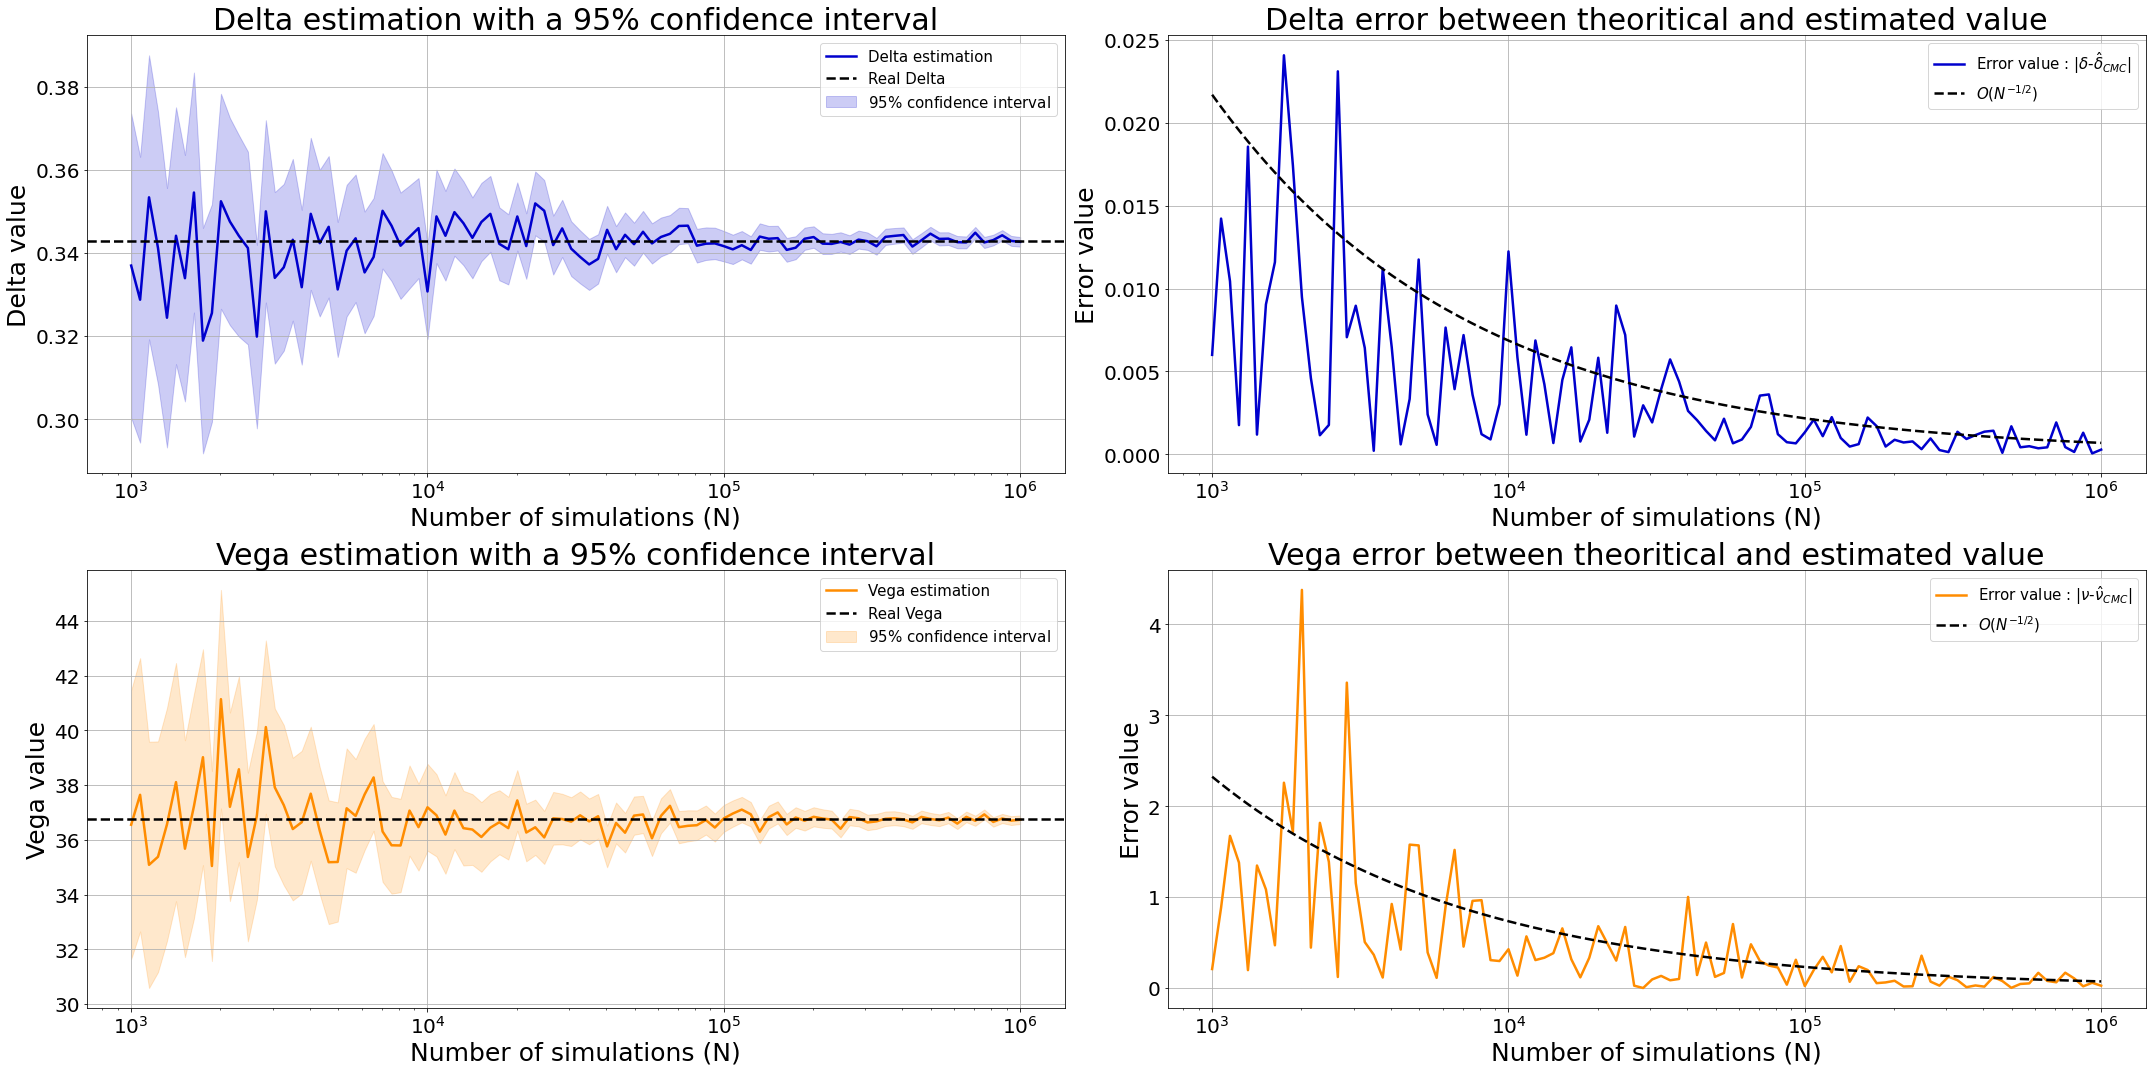

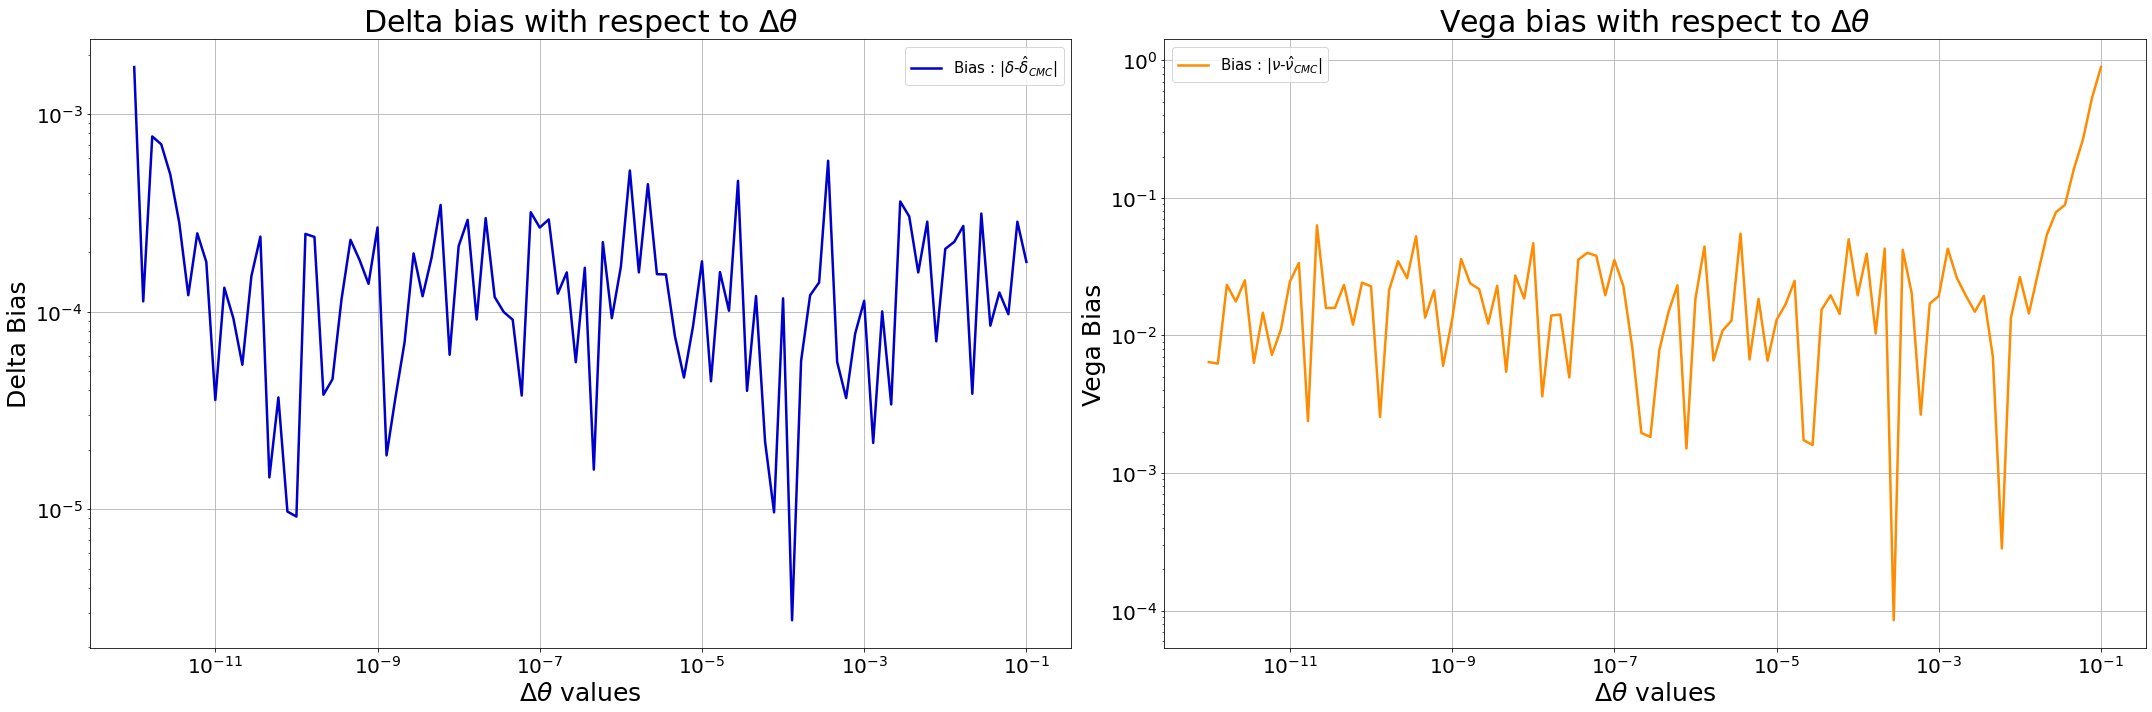

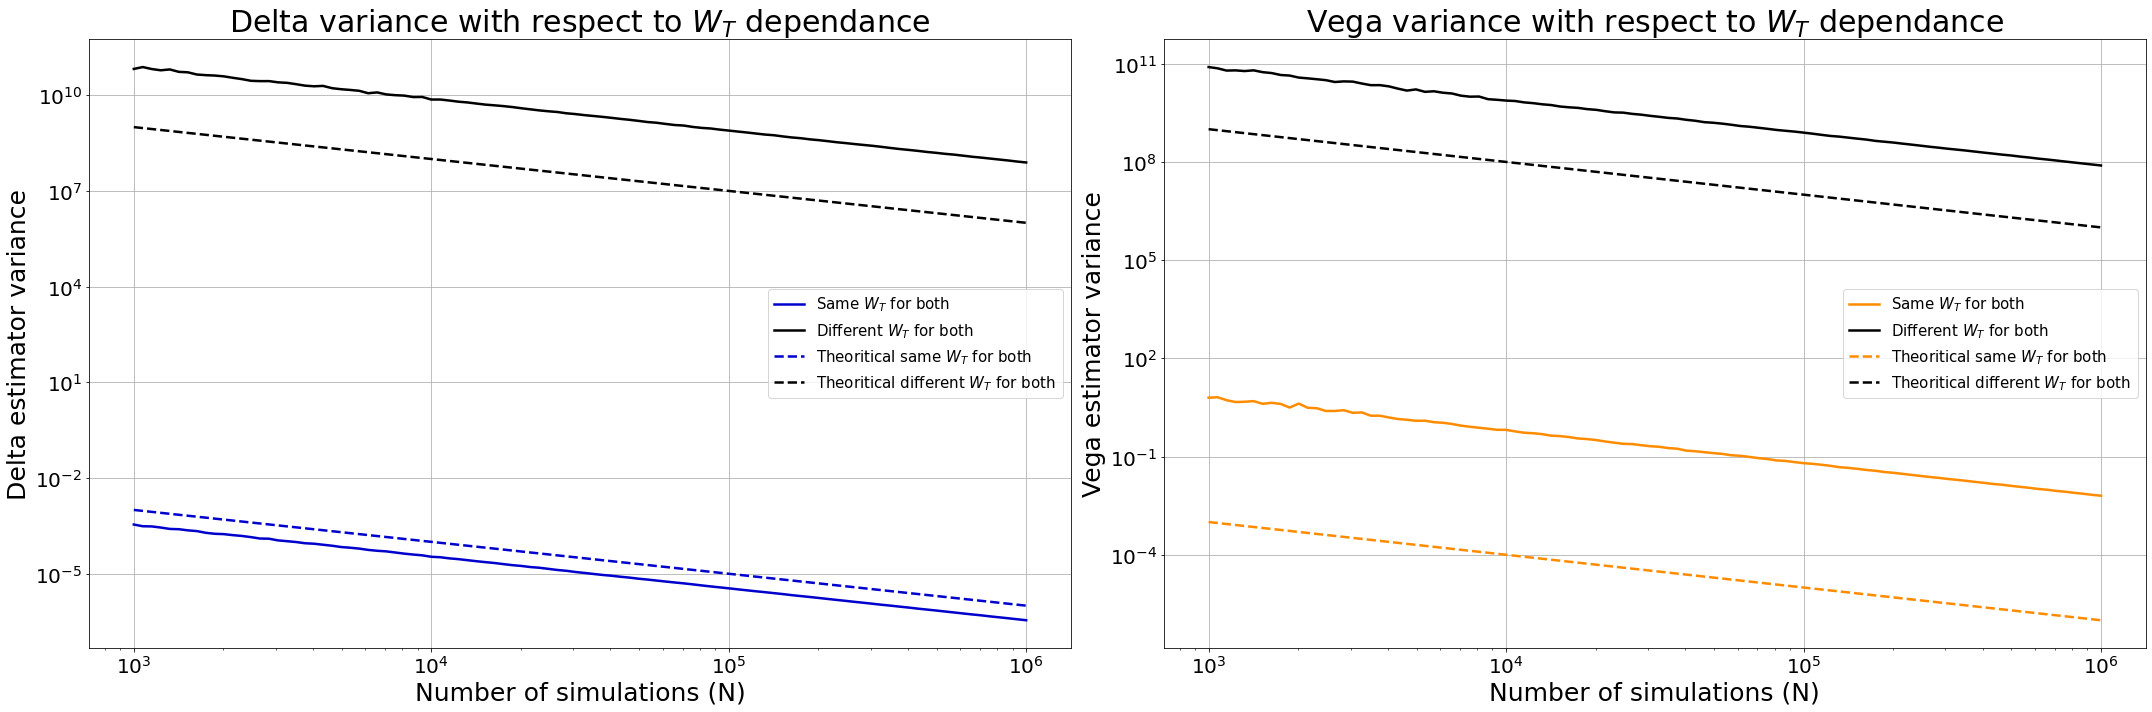

In [5]:
# Results Finite difference method

d1 : float = (np.log(S_0/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
real_val : dict = {"delta":st.norm.cdf(d1),"vega":S_0*np.sqrt(T)*st.norm.pdf(d1),"gamma":st.norm.pdf(d1)/(sig*S_0*np.sqrt(T))}
    
print("Estimated delta value with biggest N: ", finite_methods_dict["delta"][-1,0])
print("real delta value : ",real_val["delta"])
print("Variance of the delta estimator with biggest N: ", (finite_methods_dict["delta"][-1,1] **2)/n_max)

print("\n")

print("Estimated vega value with biggest N: ", finite_methods_dict["vega"][-1,0])
print("real vega value : ",real_val["vega"])
print("Variance of the vega estimator with biggest N: ", (finite_methods_dict["vega"][-1,1] **2) /n_max)


fig, ax = plt.subplots(len(greeks),2,figsize=(30,15)) #Variation of N
fig2, ax2 = plt.subplots(1,len(greeks),figsize=(30,10)) #Variation of dtheta
fig3, ax3 = plt.subplots(1,len(greeks),figsize=(30,10)) #With or without iid W_T


colors = {"delta":"mediumblue","vega":"darkorange","gamma":"#6096BA","real":"black"}
symbols = {"delta":[r"$\delta$",r"$\hat{\delta}_{CMC}$"],"vega":[r"$\nu$",r"$\hat{\nu}_{CMC}$"],"gamma":[r"$\gamma$",r"$\hat{\gamma}_{CMC}$"]}

for idx,greek in enumerate(greeks):
    
    # Figure 1
    
    # Confidence interval and mean plot
    ax[idx,0].plot(n_elem,finite_methods_dict[greek][:,0],label=greek.capitalize() + " estimation",c=colors[greek],lw=2.5)
    ax[idx,0].fill_between(n_elem, finite_methods_dict[greek][:,0] - 1.96*finite_methods_dict[greek][:,1]/np.sqrt(n_elem), 
                                 finite_methods_dict[greek][:,0] + 1.96*finite_methods_dict[greek][:,1]/np.sqrt(n_elem),
                           alpha=0.2,label=r"$95$% confidence interval",color=colors[greek])
    ax[idx,0].axhline(real_val[greek],label= "Real " + greek.capitalize(),c=colors["real"],lw=2.5, ls="--")

    ax[idx,0].set_title(f"{greek.capitalize()} estimation with a 95% confidence interval",fontsize=30)
    ax[idx,0].set_xlabel("Number of simulations (N)",size=25)
    ax[idx,0].set_ylabel(f"{greek.capitalize()} value",size=25)
    ax[idx,0].tick_params(axis='both', which='major', labelsize=20)
    ax[idx,0].legend(fontsize=15)
    ax[idx,0].set_xscale("log")
    ax[idx,0].grid()
    
    
    # Error of the estimation
    
    ax[idx,1].plot(n_elem,np.abs(real_val[greek]-finite_methods_dict[greek][:,0]),lw=2.5,
                   label=f"Error value : |{symbols[greek][0]}-{symbols[greek][1]}|",c=colors[greek])
    ax[idx,1].plot(n_elem,2*real_val[greek]/np.sqrt(n_elem),c="black",label=r"$O(N^{-1/2})$",ls="--",lw=2.5)
    ax[idx,1].set_title(f"{greek.capitalize()} error between theoritical and estimated value",fontsize=30)
    ax[idx,1].set_xlabel("Number of simulations (N)",size=25)
    ax[idx,1].set_ylabel(f"Error value",size=25)
    ax[idx,1].tick_params(axis='both', which='major', labelsize=20)
    ax[idx,1].legend(fontsize=15)
    ax[idx,1].set_xscale("log")
    ax[idx,1].grid()
    
    
    # Figure 2 : Bias wrt delta theta
    
    ax2[idx].plot(dthetas,np.abs(finite_methods_dthetas[greek][:,0] - real_val[greek]),
                  label=f"Bias : |{symbols[greek][0]}-{symbols[greek][1]}|",c=colors[greek],lw=2.5)
    ax2[idx].set_title(f"{greek.capitalize()}" + r" bias with respect to $\Delta \theta$",fontsize=30)
    ax2[idx].set_xlabel(r"$\Delta \theta $ values",size=25)
    ax2[idx].set_ylabel(f"{greek.capitalize()} Bias",size=25)
    ax2[idx].tick_params(axis='both', which='major', labelsize=20)
    ax2[idx].legend(fontsize=15)
    ax2[idx].set_xscale("log")
    ax2[idx].set_yscale("log")
    ax2[idx].grid()
    
    # Figure 3 : Variance of estimator wrt independance of W_T
    # Summarized in a table for the report
    
    ax3[idx].plot(n_elem,finite_methods_dict[greek][:,1]**2/n_elem,
                  label="Same $W_T$ for both ",c=colors[greek],lw=2.5)
    ax3[idx].plot(n_elem,finite_methods_dict_W_T_diff[greek][:,1]**2/n_elem,
                  label="Different $W_T$ for both ",c="black",lw=2.5)
    ax3[idx].plot(n_elem,1/n_elem,
              label="Theoritical same $W_T$ for both ",c=colors[greek],ls="--",lw=2.5)

    ax3[idx].plot(n_elem,1/(n_elem*dtheta**2),
                  label="Theoritical different $W_T$ for both ",c="black",ls="--",lw=2.5)
    ax3[idx].set_title(f"{greek.capitalize()}" + r" variance with respect to $W_T$ dependance",fontsize=30)
    ax3[idx].set_xlabel("Number of simulations (N)",size=25)
    ax3[idx].set_ylabel(f"{greek.capitalize()} estimator variance",size=25)
    ax3[idx].tick_params(axis='both', which='major', labelsize=20)
    ax3[idx].legend(fontsize=15)
    ax3[idx].set_xscale("log")
    ax3[idx].set_yscale("log")
    ax3[idx].grid()
    

    
fig.tight_layout()
fig2.tight_layout()
fig3.tight_layout()

#fig.savefig("./plots/3.1/FD_delta_vega_estimation.png")
#fig2.savefig("./plots/3.1/FD_bias_wrt_theta.png")
#fig3.savefig("./plots/3.1/FD_independance_W_T.png")

In [6]:
# Pathwise derivative

dSdtheta = {"delta":dS_dS0,"vega":dS_dsig}

pathwise_dict = {}
for greek in greeks:
    pathwise_dict[greek] = np.array([pathwise_deriv(dC_payoff,params,dSdtheta[greek],greek, n) for idx,n in enumerate(n_elem)])

Estimated delta value with biggest N:  0.3426963440736607
real delta value :  0.34300112611322126
Variance of the delta estimator with biggest N:  3.4907533710318976e-07


Estimated vega value with biggest N:  36.79731622767272
real vega value :  36.76359083901262
Variance of the vega estimator with biggest N:  0.006356564703403266


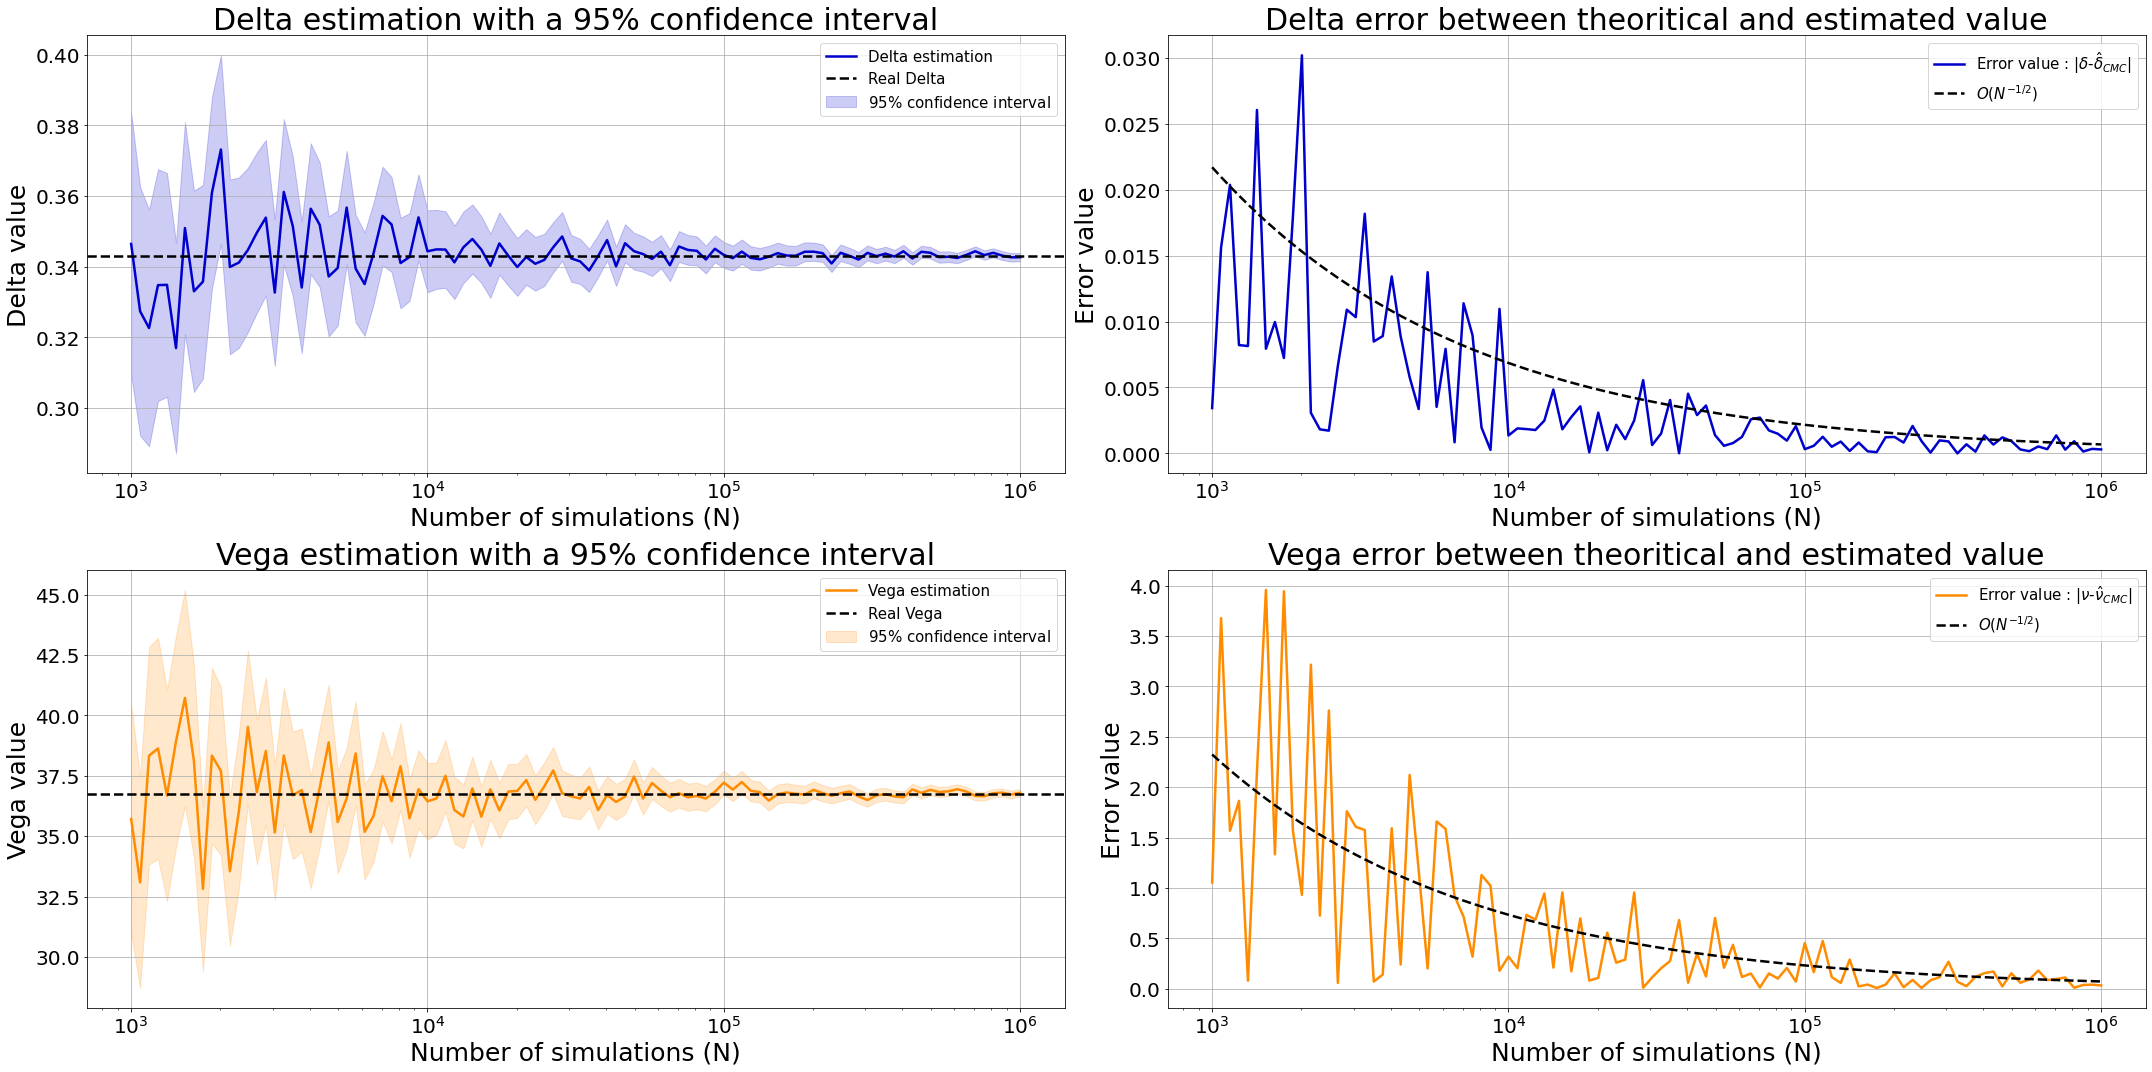

In [7]:
# Pathwise derivative

print("Estimated delta value with biggest N: ", pathwise_dict["delta"][-1,0])
print("real delta value : ",real_val["delta"])
print("Variance of the delta estimator with biggest N: ", (pathwise_dict["delta"][-1,1] **2)/n_max)

print("\n")

print("Estimated vega value with biggest N: ", pathwise_dict["vega"][-1,0])
print("real vega value : ",real_val["vega"])
print("Variance of the vega estimator with biggest N: ", (pathwise_dict["vega"][-1,1] **2) /n_max)

fig, ax = plt.subplots(len(greeks),2,figsize=(30,15)) #Variation of N


for idx,greek in enumerate(greeks):
    
    # Confidence interval and mean plot
    
    ax[idx,0].plot(n_elem,pathwise_dict[greek][:,0],label=greek.capitalize() + " estimation",c=colors[greek],lw=2.5)
    ax[idx,0].fill_between(n_elem, pathwise_dict[greek][:,0] - 1.96*pathwise_dict[greek][:,1]/np.sqrt(n_elem), 
                                 pathwise_dict[greek][:,0] + 1.96*pathwise_dict[greek][:,1]/np.sqrt(n_elem),
                           alpha=0.2,label=r"$95$% confidence interval",color=colors[greek])
    ax[idx,0].axhline(real_val[greek],label= "Real " + greek.capitalize(),c=colors["real"],lw=2.5, ls="--")
    ax[idx,0].set_title(f"{greek.capitalize()} estimation with a 95% confidence interval",fontsize=30)
    ax[idx,0].set_xlabel("Number of simulations (N)",size=25)
    ax[idx,0].set_ylabel(f"{greek.capitalize()} value",size=25)
    ax[idx,0].tick_params(axis='both', which='major', labelsize=20)
    ax[idx,0].legend(fontsize=15)
    ax[idx,0].set_xscale("log")
    ax[idx,0].grid()
    
    
    # Error of the estimation
    ax[idx,1].plot(n_elem,np.abs(real_val[greek]-pathwise_dict[greek][:,0]),lw=2.5,
                   label=f"Error value : |{symbols[greek][0]}-{symbols[greek][1]}|",c=colors[greek])
    ax[idx,1].plot(n_elem,2*real_val[greek]/np.sqrt(n_elem),c="black",label=r"$O(N^{-1/2})$",ls="--",lw=2.5)
    ax[idx,1].set_title(f"{greek.capitalize()} error between theoritical and estimated value",fontsize=30)
    ax[idx,1].set_xlabel("Number of simulations (N)",size=25)
    ax[idx,1].set_ylabel(f"Error value",size=25)
    ax[idx,1].tick_params(axis='both', which='major', labelsize=20)
    ax[idx,1].legend(fontsize=15)
    ax[idx,1].set_xscale("log")
    ax[idx,1].grid()
    
fig.tight_layout()
#fig.savefig("./plots/3.1/PD_delta_vega_estimation.png")

In [8]:
# Likelihood Ratio

dpdS0 = lambda x,p: 1/(p[1]*p[3]**2*p[0])*(np.log(x/p[1])-(p[2]-0.5*p[3]**2)*p[0])

dpdSigma = lambda x,p: -1/p[3] - 1/(p[3]*np.sqrt(p[0]))*(np.log(x/p[1])-(p[2]-0.5*p[3]**2)*p[0])*\
                        ((p[2]*p[0]-np.log(x/p[1]))/(np.sqrt(p[0])*p[3]**2) + 0.5*np.sqrt(p[0]))

dp_tot = {"delta":dpdS0,"vega":dpdSigma}

LR_dict = {}
for greek in greeks:
    LR_dict[greek] = np.array([likelihood_ratio(C_payoff,dp_tot[greek],params,greek, n) for idx,n in enumerate(n_elem)])

Estimated delta value with biggest N:  0.34338721194221655
real delta value :  0.34300112611322126
Variance of the delta estimator with biggest N:  1.2622587987526167e-06


Estimated vega value with biggest N:  36.827209614875635
real vega value :  36.76359083901262
Variance of the vega estimator with biggest N:  0.05041536302794122


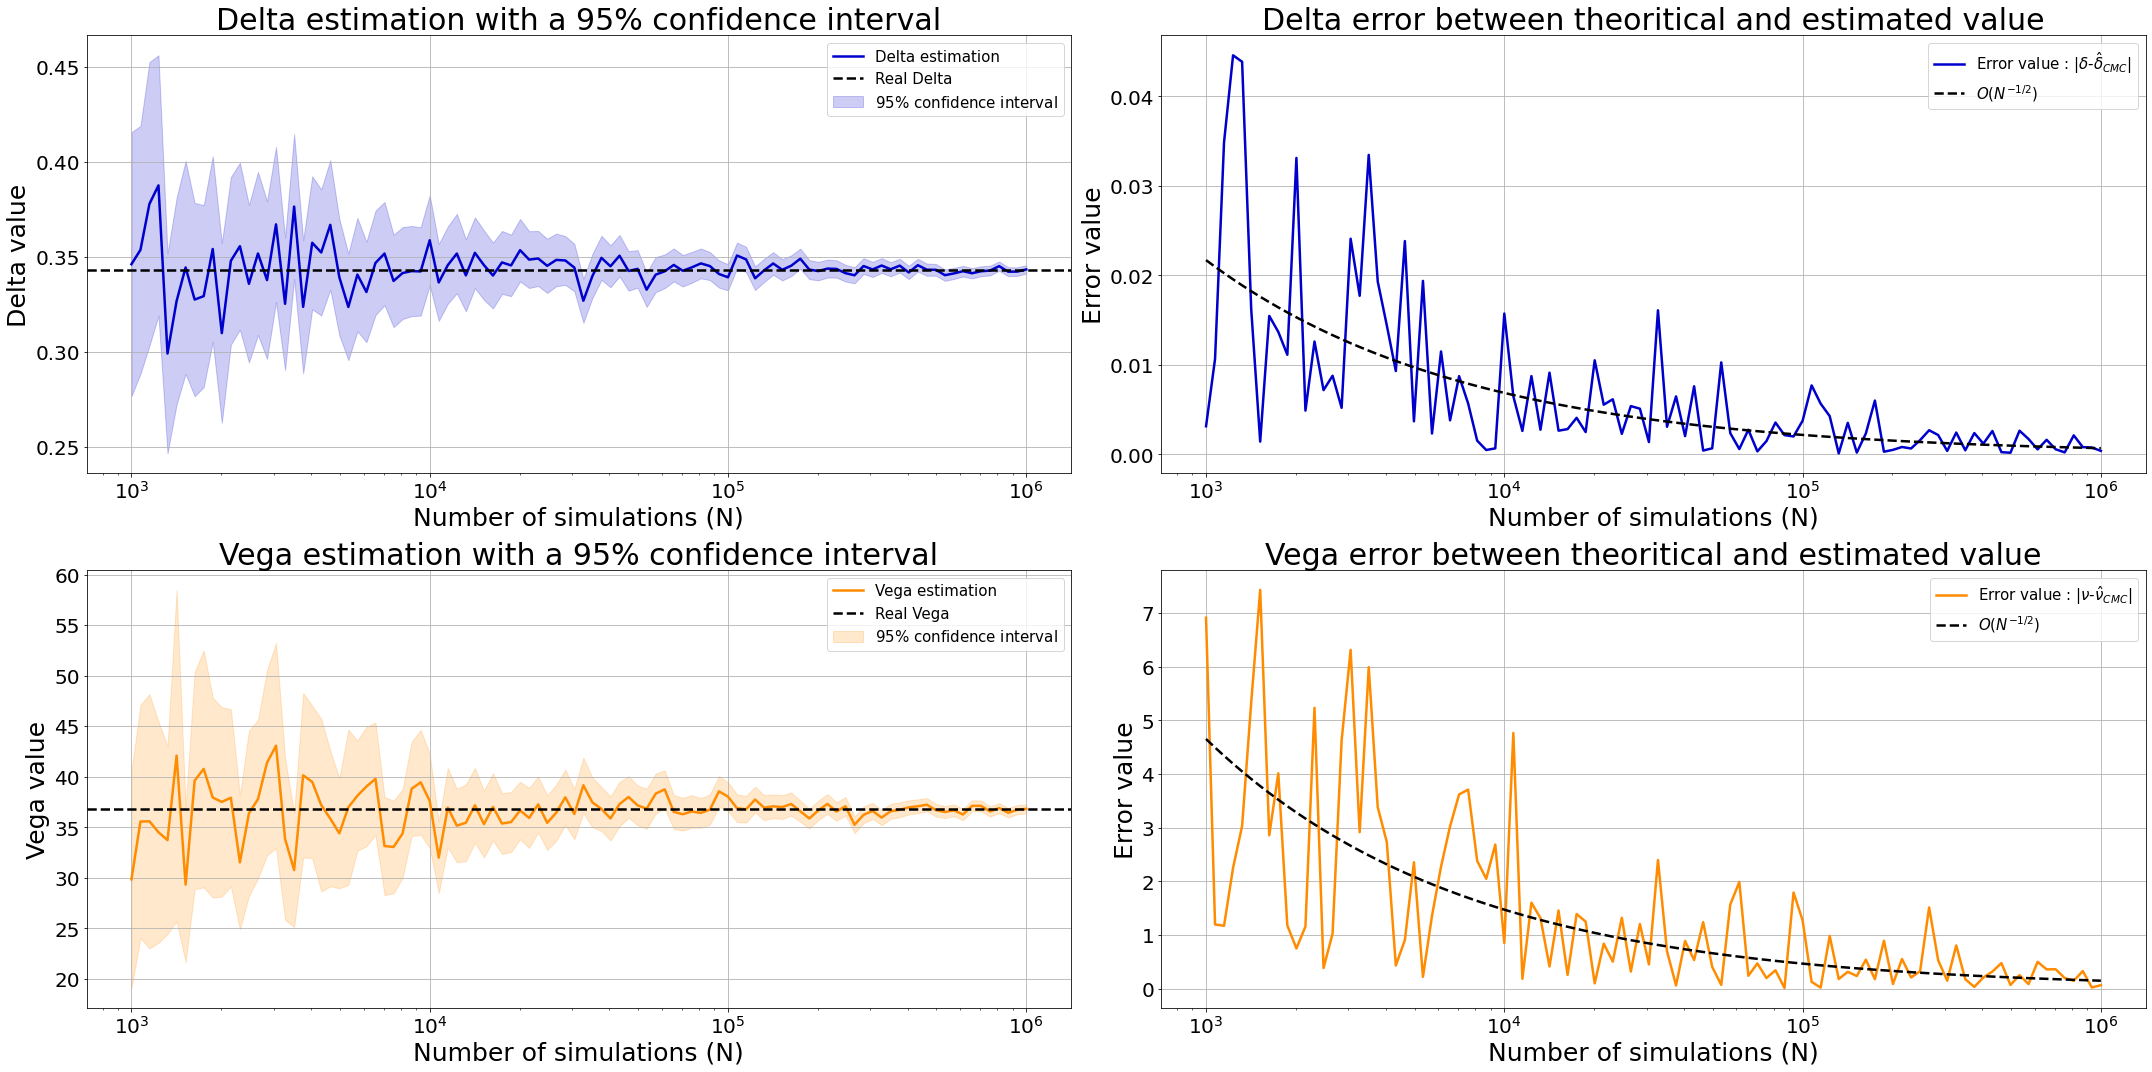

In [9]:
print("Estimated delta value with biggest N: ", LR_dict["delta"][-1,0])
print("real delta value : ",real_val["delta"])
print("Variance of the delta estimator with biggest N: ", (LR_dict["delta"][-1,1] **2) /n_max)
print("\n")
print("Estimated vega value with biggest N: ", LR_dict["vega"][-1,0])
print("real vega value : ",real_val["vega"])
print("Variance of the vega estimator with biggest N: ", (LR_dict["vega"][-1,1] **2)/n_max)


fig, ax = plt.subplots(len(greeks),2,figsize=(30,15))

for idx,greek in enumerate(greeks):
    
    # Confidence interval and mean plot
    
    ax[idx,0].plot(n_elem,LR_dict[greek][:,0],label=greek.capitalize() + " estimation",c=colors[greek],lw=2.5)
    ax[idx,0].fill_between(n_elem, LR_dict[greek][:,0] - 1.96*LR_dict[greek][:,1]/np.sqrt(n_elem), 
                                 LR_dict[greek][:,0] + 1.96*LR_dict[greek][:,1]/np.sqrt(n_elem),
                           alpha=0.2,label=r"$95$% confidence interval",color=colors[greek])
    ax[idx,0].axhline(real_val[greek],label= "Real " + greek.capitalize(),c=colors["real"],lw=2.5, ls="--")
    ax[idx,0].set_title(f"{greek.capitalize()} estimation with a 95% confidence interval",fontsize=30)
    ax[idx,0].set_xlabel("Number of simulations (N)",size=25)
    ax[idx,0].set_ylabel(f"{greek.capitalize()} value",size=25)
    ax[idx,0].tick_params(axis='both', which='major', labelsize=20)
    ax[idx,0].legend(fontsize=15)
    ax[idx,0].set_xscale("log")
    ax[idx,0].grid()
    
    
    # Error of the estimation
    ax[idx,1].plot(n_elem,np.abs(real_val[greek]-LR_dict[greek][:,0]),lw=2.5,
                   label=f"Error value : |{symbols[greek][0]}-{symbols[greek][1]}|",c=colors[greek])
    if greek == "delta":
        ax[idx,1].plot(n_elem,2*real_val[greek]/np.sqrt(n_elem),c="black",label=r"$O(N^{-1/2})$",ls="--",lw=2.5)
    else:
        ax[idx,1].plot(n_elem,4*real_val[greek]/np.sqrt(n_elem),c="black",label=r"$O(N^{-1/2})$",ls="--",lw=2.5)
    ax[idx,1].set_title(f"{greek.capitalize()} error between theoritical and estimated value",fontsize=30)
    ax[idx,1].set_xlabel("Number of simulations (N)",size=25)
    ax[idx,1].set_ylabel(f"Error value",size=25)
    ax[idx,1].tick_params(axis='both', which='major', labelsize=20)
    ax[idx,1].legend(fontsize=15)
    ax[idx,1].set_xscale("log")
    ax[idx,1].grid()
fig.tight_layout()
#fig.savefig("./plots/3.1/LR_delta_vega_estimation.png")

### Estimation of Gamma

In [10]:
gamma_est = {}

print("Real value of gamma: ",real_val["gamma"])

#Using twice the likelihood Ratio method (LRLR)
ddpdS0 = lambda x,p: -(1 +np.log(x/p[1]) - (p[2] -0.5*p[3]**2)*p[0])/(p[0] * p[1]**2 * p[3]**2) + (1/(p[1]*p[3]**2*p[0])*(np.log(x/p[1])-(p[2]-0.5*p[3]**2)*p[0]))**2


gamma_est["LRLR"] = np.array([likelihood_ratio(C_payoff,ddpdS0,params,"gamma", n) for idx,n in enumerate(n_elem)])

print("the approximation of gamma with twice the LR method is ",gamma_est["LRLR"][-1,0], " with relative error ", np.abs(gamma_est["LRLR"][-1,0] - real_val["gamma"])/real_val["gamma"] )

#using pathwise and then likelihood ratio (PDLR)

dp_PDLR = lambda x,p : dpdS0(x,p)-1/p[1]

g = lambda x,p : np.exp(-p[0]*p[2])*(x >= p[4])*x/p[1]

gamma_est["PDLR"] = np.array([likelihood_ratio(g,dp_PDLR,params,"gamma", n) for idx,n in enumerate(n_elem)])

print("the approximation of gamma with Pathwise derivative then the LR method is ",gamma_est["PDLR"][-1,0], " with relative error ", np.abs(gamma_est["PDLR"][-1,0] - real_val["gamma"])/real_val["gamma"])

#Using LR then pathwise derivative (LRPD):
h = lambda x,p : (dC_payoff(x,p)*x-C_payoff(x,p))*dpdS0(x,p)/p[1]

dummy = lambda x,p : 1 # dummy function to use the function pathwise_deriv

gamma_est["LRPD"] = np.array([pathwise_deriv(h,params,dummy,"combination", n) for idx,n in enumerate(n_elem)])

print("the approximation of gamma with LR then pathwise derivative ",gamma_est["LRPD"][-1,0], " with relative error ", np.abs(gamma_est["LRPD"][-1,0] - real_val["gamma"])/real_val["gamma"])

Real value of gamma:  0.01470543633560505
the approximation of gamma with twice the LR method is  0.014932340596042672  with relative error  0.015429957687704814
the approximation of gamma with Pathwise derivative then the LR method is  0.014671433947261824  with relative error  0.0023122325354534685
the approximation of gamma with LR then pathwise derivative  0.014775546296287292  with relative error  0.004767621924450563


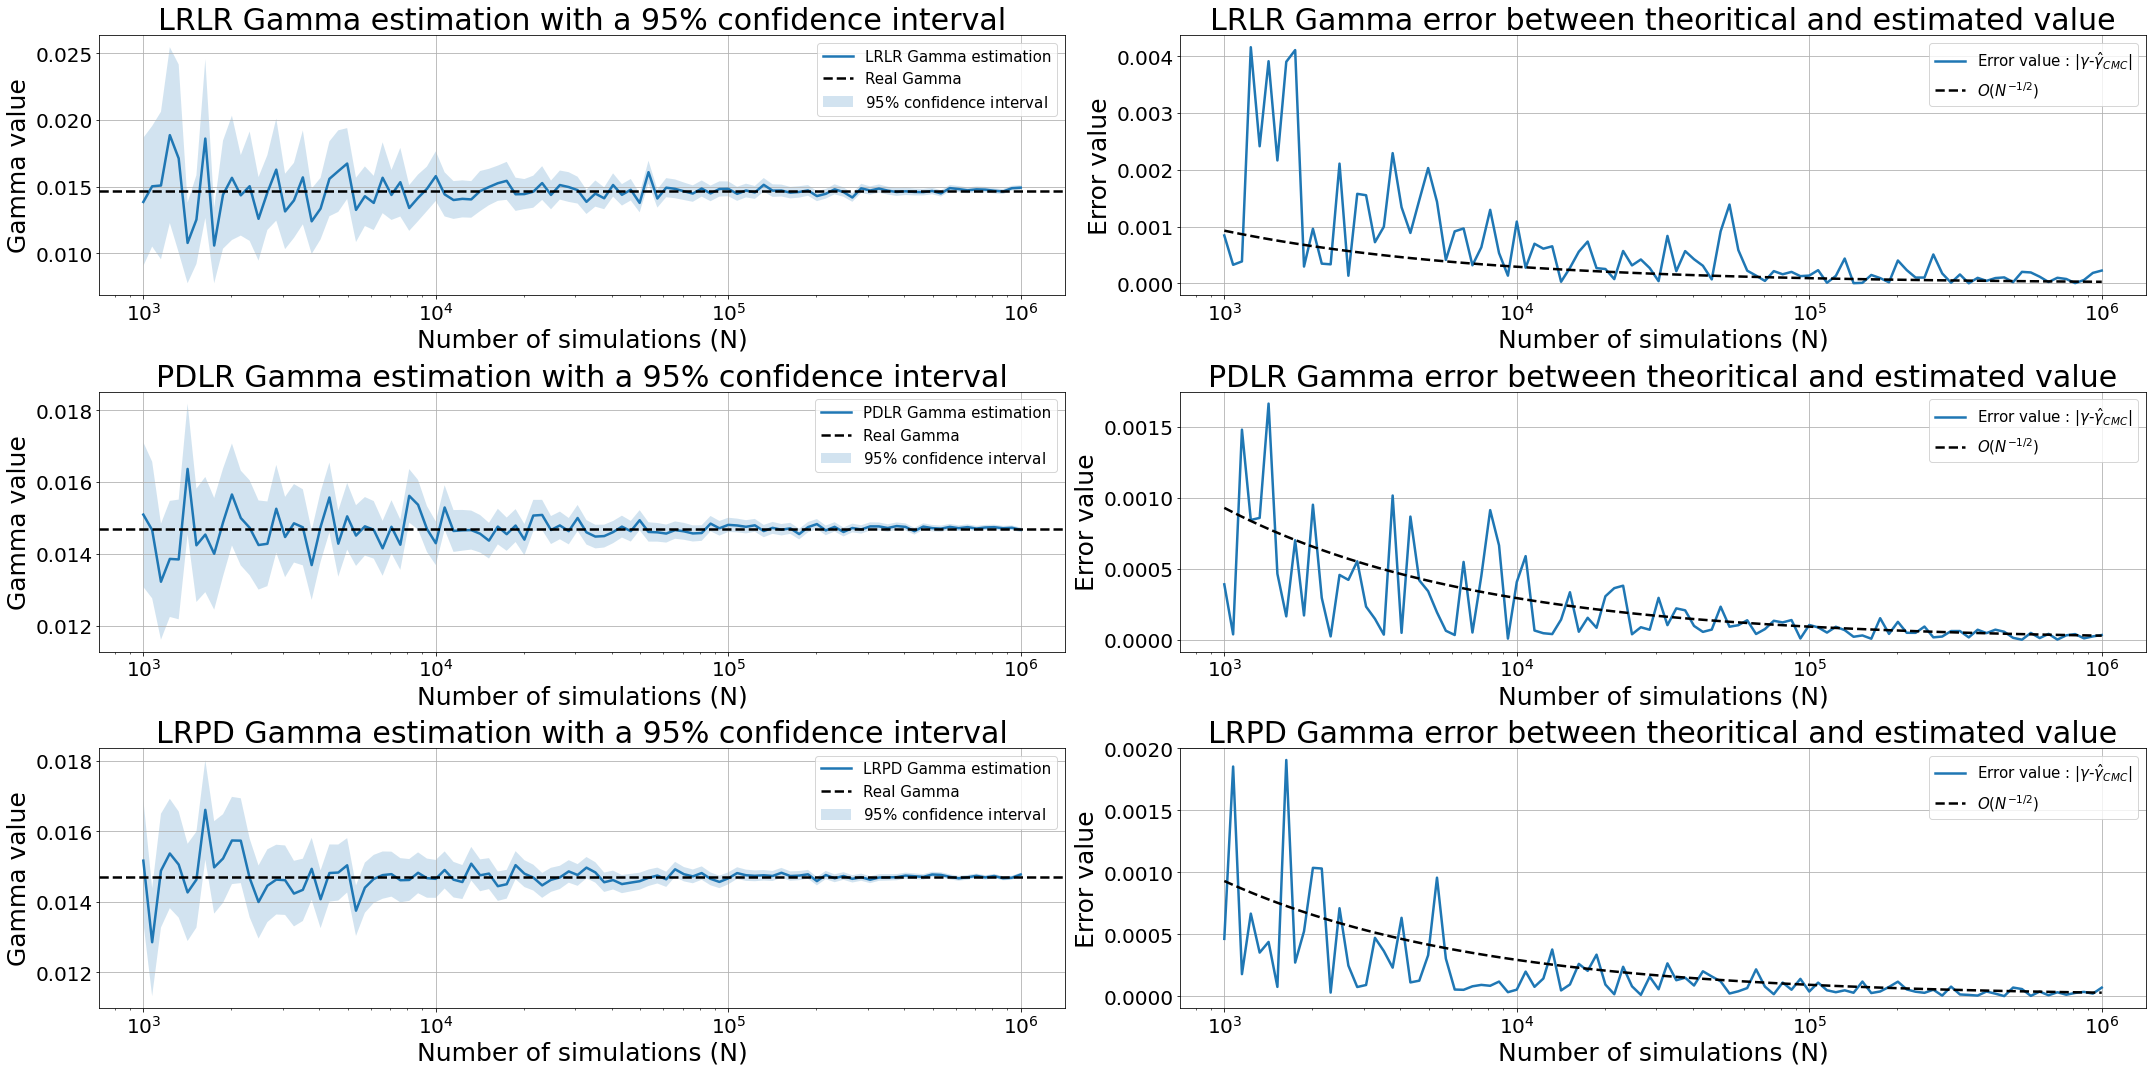

In [11]:
fig, ax = plt.subplots(len(list(gamma_est.keys())),2,figsize=(30,15))

for idx, method in enumerate(list(gamma_est.keys())):    
    # Confidence interval and mean plot
    
    ax[idx,0].plot(n_elem,gamma_est[method][:,0],label=method+" Gamma estimation",lw=2.5)
    ax[idx,0].fill_between(n_elem, gamma_est[method][:,0] - 1.96*gamma_est[method][:,1]/np.sqrt(n_elem), 
                                 gamma_est[method][:,0] + 1.96*gamma_est[method][:,1]/np.sqrt(n_elem),
                           alpha=0.2,label=r"$95$% confidence interval")
    ax[idx,0].axhline(real_val["gamma"],label= "Real Gamma",c=colors["real"],lw=2.5, ls="--")
    ax[idx,0].set_title(method+" Gamma estimation with a 95% confidence interval",fontsize=30)
    ax[idx,0].set_xlabel("Number of simulations (N)",size=25)
    ax[idx,0].set_ylabel("Gamma value",size=25)
    ax[idx,0].tick_params(axis='both', which='major', labelsize=20)
    ax[idx,0].legend(fontsize=15)
    ax[idx,0].set_xscale("log")
    ax[idx,0].grid()
    
    # Error of the estimation
    
    ax[idx,1].plot(n_elem,np.abs(real_val["gamma"]-gamma_est[method][:,0]),lw=2.5,
                   label=f"Error value : |{symbols['gamma'][0]}-{symbols['gamma'][1]}|")
    ax[idx,1].plot(n_elem,2*real_val["gamma"]/np.sqrt(n_elem),c="black",label=r"$O(N^{-1/2})$",ls="--",lw=2.5)
    ax[idx,1].set_title(method+" Gamma error between theoritical and estimated value",fontsize=30)
    ax[idx,1].set_xlabel("Number of simulations (N)",size=25)
    ax[idx,1].set_ylabel("Error value",size=25)
    ax[idx,1].tick_params(axis='both', which='major', labelsize=20)
    ax[idx,1].legend(fontsize=15)
    ax[idx,1].set_xscale("log")
    ax[idx,1].grid()
    
fig.tight_layout()

#fig.savefig("./plots/3.1/estimations_gamma.png")

## Mixed estimators for Digital call option

In [12]:
# Parameters
eps : float = 20
S_0 : float = 100
K : float = 100
T : float = 0.25
r : float = 0.05
sig : float = 0.25
params : list = [T,S_0,r,sig,K,eps]

func = lambda x,p : np.exp(-p[0]*p[2])*(x>p[4])

f_e = lambda x,p : np.minimum(np.ones(len(x)),np.maximum(np.zeros(len(x)),0.5*(x-p[4]+p[5])/p[5]))   
h_e = lambda x,p : (x>p[4])-f_e(x,p)

d_f_e = lambda x,p : 1/(2*p[5])*(x <= p[4]+p[5])*(p[4]-p[5] <= x)

N : int = 10**6

# Pilot run to compute optimal number of samples for each estimator
    
pilot_PD_f_e = pathwise_deriv(d_f_e, params,dS_dS0,"delta", int(N/2))
pilot_LR_h_e = likelihood_ratio(h_e,dpdS0,params,"delta",int(N/2))

var_tot_pilot = lambda m : np.exp(-2*params[2]*params[0])*(pilot_PD_f_e[1]**2/m + pilot_LR_h_e[1]**2/(N-m))

print("Pilot Approximated delta for the binary option :", np.exp(-params[2]*params[0])*(pilot_PD_f_e[0]+pilot_LR_h_e[0]))
print("Pilot Total Variance of estimator : ", var_tot_pilot(N/2))
m_opt_list = [int(N*(pilot_PD_f_e[1] - np.sqrt(pilot_PD_f_e[1]*pilot_LR_h_e[1]))/(pilot_PD_f_e[1]-pilot_LR_h_e[1])),
              int(N*(pilot_PD_f_e[1] + np.sqrt(pilot_PD_f_e[1]*pilot_LR_h_e[1]))/(pilot_PD_f_e[1]-pilot_LR_h_e[1]))]


print("Roots : ",m_opt_list)

# Testing which root we want to select

eligible = [(0 <= m_opt_list[0]) and (m_opt_list[0] <= N),
            (0 <= m_opt_list[1]) and (m_opt_list[1] <= N)]

if eligible == [False,False]:
    print("no optimal m found within bounds [0,N]")
    m_opt = N/2
    print("Setting m_opt = N/2")
elif eligible == [True,True]:
    print("Both are eligible, taking the least for var_tot")
    m_opt = m_opt_list[np.argmin([var_tot_pilot(m_opt_list[0]),var_tot_pilot(m_opt_list[1])])]
    print("Chosen : ",m_opt)
else:
    print("Only one eligible",eligible)
    m_opt = m_opt_list[0]*eligible[0] + m_opt_list[1]*eligible[1] # Only keeping the eligible one
    print("Chosen : ",m_opt)
print("\n")

PD_f_e = pathwise_deriv(d_f_e, params,dS_dS0,"delta", m_opt)
LR_h_e = likelihood_ratio(h_e,dpdS0,params,"delta",N-m_opt)
print("Approximated delta for the binary option :", np.exp(-params[2]*params[0])*(PD_f_e[0]+LR_h_e[0]))
print("Total Variance of estimator : ",  np.exp(-2*params[2]*params[0])*(PD_f_e[1]**2/m_opt + LR_h_e[1]**2/(N-m_opt)))

Pilot Approximated delta for the binary option : 0.0314897097268755
Pilot Total Variance of estimator :  1.9674306126110417e-10
Roots :  [543343, 6267891]
Only one eligible [True, False]
Chosen :  543343


Approximated delta for the binary option : 0.031508763741060826
Total Variance of estimator :  1.9217608280828856e-10


In [13]:
# Computing the total variances for each value of epsilon
epsilons = np.arange(0,80+1)
tot_var = np.zeros(len(epsilons))
run_params = params.copy()
for idx,ep in enumerate(epsilons):
    if ep != 0:
        run_params[5] = ep
        PD_f_e = pathwise_deriv(d_f_e, run_params,dS_dS0,"delta", m_opt)
        LR_h_e = likelihood_ratio(h_e,dpdS0,run_params,"delta",N-m_opt)
        tot_var[idx] = np.exp(-2*params[2]*params[0])*(PD_f_e[1]**2/m_opt + LR_h_e[1]**2/(N-m_opt))
    else:
        LR_f = likelihood_ratio(func,dpdS0,params,"delta",N)
        tot_var[idx] = LR_f[1]**2/N

optimal epsilon found :  26


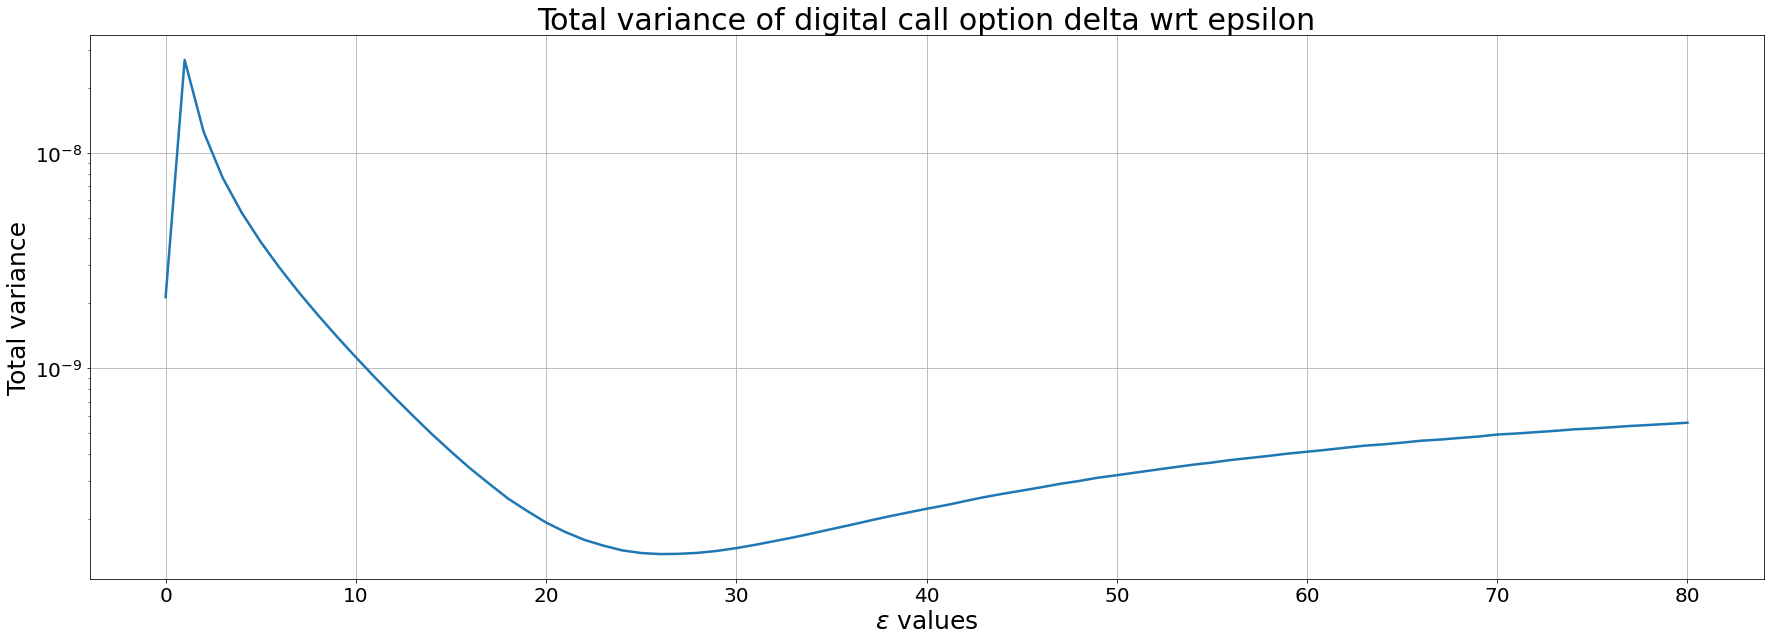

In [14]:
fig, ax = plt.subplots(1,figsize=(30,10))
ax.plot(epsilons,tot_var,lw=2.5)
ax.set_yscale("log")
ax.set_title("Total variance of digital call option delta wrt epsilon",size=30)
ax.set_xlabel("$\epsilon$ values",size=25)
ax.set_ylabel("Total variance",size=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.grid()
#fig.savefig("plots/3.2/epsilon.png")

print("optimal epsilon found : ",epsilons[np.argmin(tot_var)])

In [15]:
# Final value of delta :

params : list = [T,S_0,r,sig,K,epsilons[np.argmin(tot_var)]]

func = lambda x,p : np.exp(-p[0]*p[2])*(x>p[4])

f_e = lambda x,p : np.minimum(np.ones(len(x)),np.maximum(np.zeros(len(x)),0.5*(x-p[4]+p[5])/p[5]))   
h_e = lambda x,p : (x>p[4])-f_e(x,p)

d_f_e = lambda x,p : 1/(2*p[5])*(x <= p[4]+p[5])*(p[4]-p[5] <= x)

N : int = 10**6
    
PD_f_e = pathwise_deriv(d_f_e, params,dS_dS0,"delta", m_opt)
LR_h_e = likelihood_ratio(h_e,dpdS0,params,"delta",N-m_opt)
var = np.exp(-2*params[2]*params[0])*(PD_f_e[1]**2/m_opt + LR_h_e[1]**2/(N-m_opt))

delta,_ = (PD_f_e+LR_h_e)*np.exp(-params[0]*params[2])
print("Final value of delta: ", delta)
print("with standard deviation: ", np.sqrt(var))

Final value of delta:  0.0315029360008236
with standard deviation:  1.1717901788560328e-05
